In [1]:
!git clone https://github.com/satyaNekkantiCompVison/pytorch_visionmodels.git

fatal: destination path 'pytorch_visionmodels' already exists and is not an empty directory.


In [2]:
!pip install --upgrade albumentations
# !pip install torch-lr-finder

# Change Directory to main repo

In [3]:
cd /content/pytorch_visionmodels/

/content/pytorch_visionmodels


## Get Helper functions

In [5]:
from utils.helper import seed_everything, get_device, model_summary
seed_everything(42)
device = get_device()

CUDA Available: True


## Custom Augmnetation


In [4]:
import albumentations as A
train_aug = A.Compose(
    {      
     A.Sequential([
                   A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by defaulf
                   A.RandomCrop(32,32)
                   ]),
     A.HorizontalFlip(always_apply=False,p=0.1),
     A.CoarseDropout(1, 8, 8, 1, 8, 8,fill_value=0.473363, mask_fill_value=None, always_apply=False,p=0.1),
     A.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262))
     }
     )

## Loading Train and Test loader

In [6]:
from utils.data_augmentations import get_train_loader_tinyImageNet, get_test_loader_tinyImageNet
train_loader = get_train_loader_tinyImageNet(BATCH_SIZE=512,AugTransforms=train_aug )
test_loader = get_test_loader_tinyImageNet(BATCH_SIZE=512)

Files already downloaded and verified
Files already downloaded and verified


## Custom ResNet Model summary with Batch Normalization

In [7]:
from models.custom_resnet import CustomResNet
from utils.helper import model_summary

model = CustomResNet().to(device)

model_summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        MaxPool2d-14            [-1, 25

# Finding Learning Rating in pytorch

In [8]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

epochs = 50
lr = 0.01
l1_factor = 0

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.005)
criterion = nn.CrossEntropyLoss()

## Training and Testing model


In [11]:
from main import fit_model

scheduler_type = "OneCycleLR"
scheduler_params = {}
scheduler_params["max_lr"] = lr
scheduler_params["div_factor"] = 16
scheduler_params["three_phase"] = False
scheduler_params["anneal_strategy"] = "linear"
scheduler_params["max_epoch"] = 5
 
experiment_parameters = fit_model(model, device, epochs, train_loader,test_loader,optimizer,criterion,0, scheduler_type, scheduler_params)

Epoch 1:


  0%|          | 0/151 [00:01<?, ?it/s]


RuntimeError: ignored

## Plotting graphs



## Plotting Loss graphs

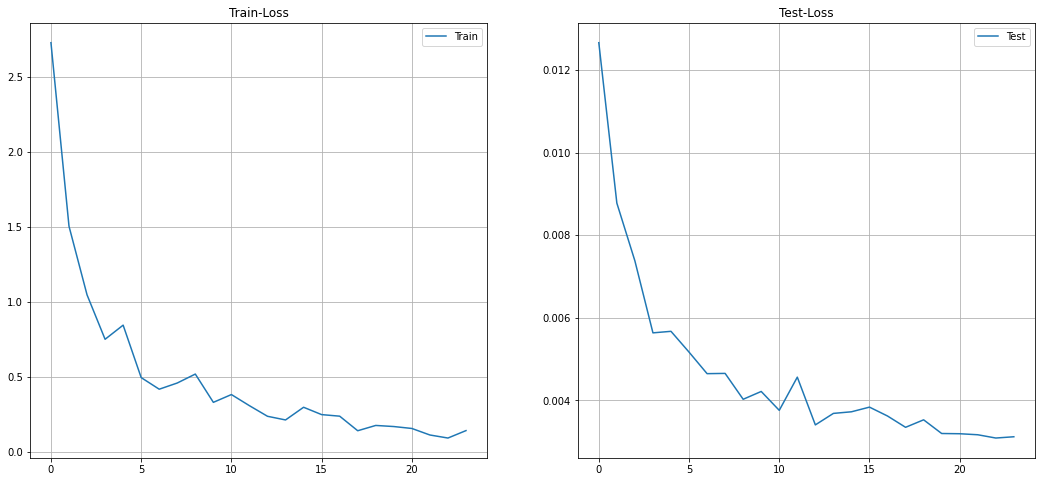

In [ ]:
from utils.plot_images import plot_Lossaxis, plot_Accaxis
train_Acc,train_Loss, test_Acc, test_Loss = experiment_parameters
new_trainAcc  = []
new_trainloss = []

datavalue = range(0,len(train_Acc),391)
for i in datavalue:
  new_trainAcc.append(train_Acc[i])
  new_trainloss.append(train_Loss[i])


plot_Lossaxis(new_trainloss,test_Loss)


## Plotting Test graph

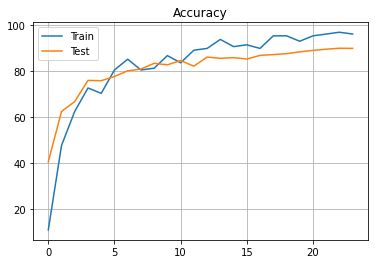

In [ ]:
plot_Accaxis(new_trainAcc,test_Acc)

## Plotting misclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total wrong predictions are 1014


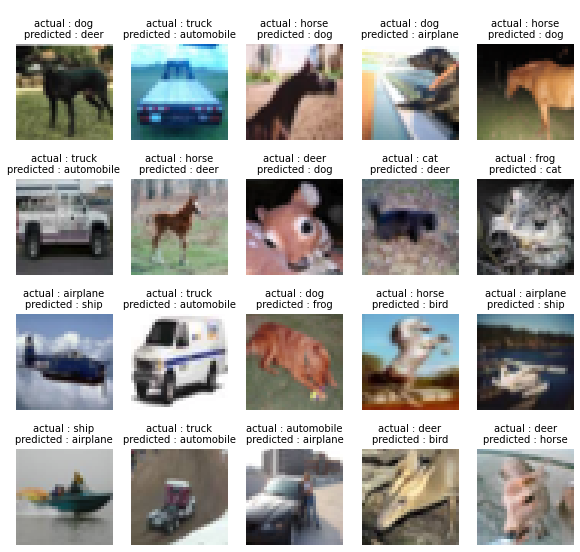

In [ ]:
from utils.plot_images import misclassified_images
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

images_misclassified = misclassified_images(model, test_loader, device)

## GradCAM output for misclassified images

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Generating Grad-CAM for Conv1Layer
Generating Grad-CAM for Conv2Layer
Generating Grad-CAM for Conv3Layer


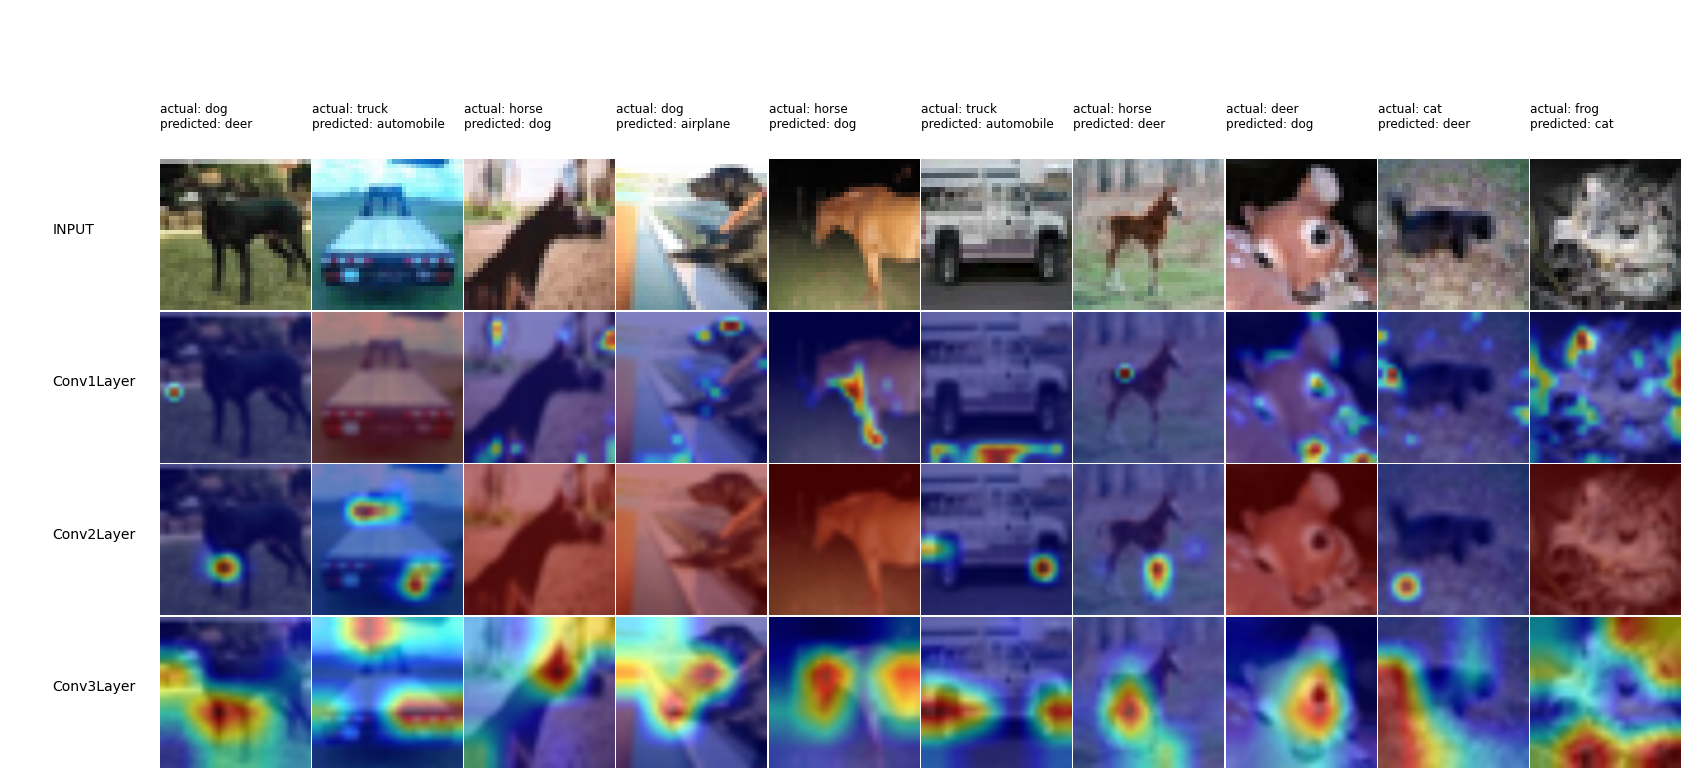

Generating Grad-CAM for Conv1Layer
Generating Grad-CAM for Conv2Layer
Generating Grad-CAM for Conv3Layer


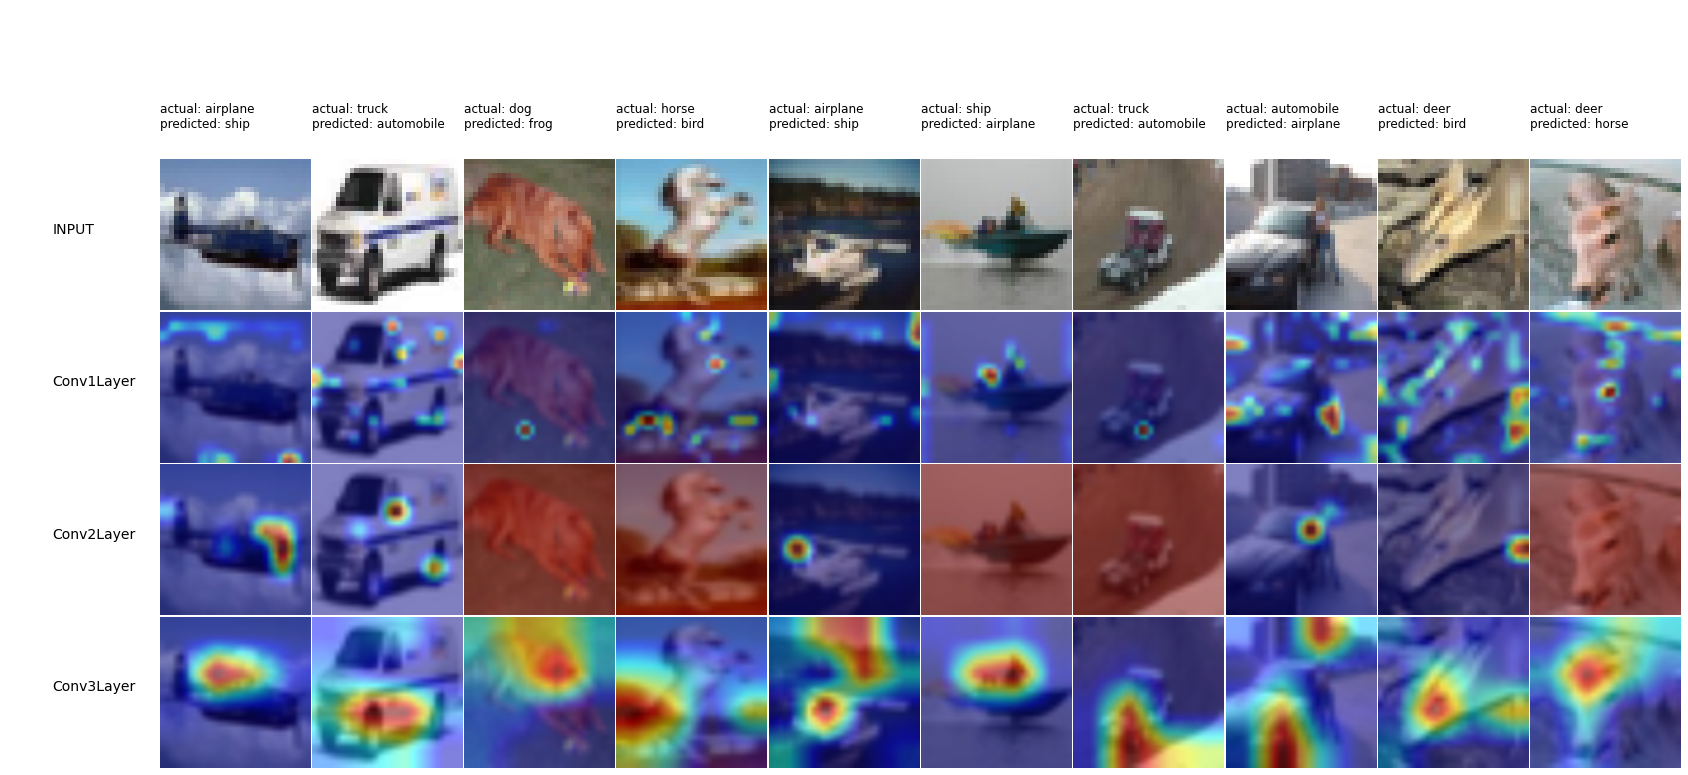

In [ ]:
# from utils.gradcam import generate_gradcam, plot_gradcam
target_layers = ["Conv1Layer","Conv2Layer","Conv3Layer"]
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# Plot 10 misclassifed images
gradcam_output, probs, predicted_classes = generate_gradcam(images_misclassified[:10], model, target_layers, device)
plot_gradcam(gradcam_output, target_layers, labels, (3, 32, 32), predicted_classes, images_misclassified[:10])

# plot another 10 misclassified images
gradcam_output, probs, predicted_classes = generate_gradcam(images_misclassified[10:20], model, target_layers, device)
plot_gradcam(gradcam_output, target_layers, labels, (3, 32, 32), predicted_classes, images_misclassified[10:20])